In [15]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


In [16]:
print(len(tf.config.list_physical_devices('GPU')))
!clear

1


In [17]:
# !ls classification_dataset
lst = os.listdir('dataset/dataset extract')
print(len(lst))

1000


In [18]:
# Parameters
IMAGE_WIDTH = 32 
IMAGE_HEIGHT = 32
BATCH_SIZE = 16
n_classes = 34
train_dir = 'classification_dataset/all'
test_dir = 'classification_dataset/test/all'

In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_generator = datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    subset='training'
    
)
valid_generator = datagen.flow_from_directory(
    train_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    subset='validation'
)

testgen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)
test_generator = testgen.flow_from_directory(
    test_dir,
    shuffle=True,
    batch_size = BATCH_SIZE,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
)

Found 3522 images belonging to 34 classes.
Found 864 images belonging to 34 classes.
Found 1082 images belonging to 34 classes.


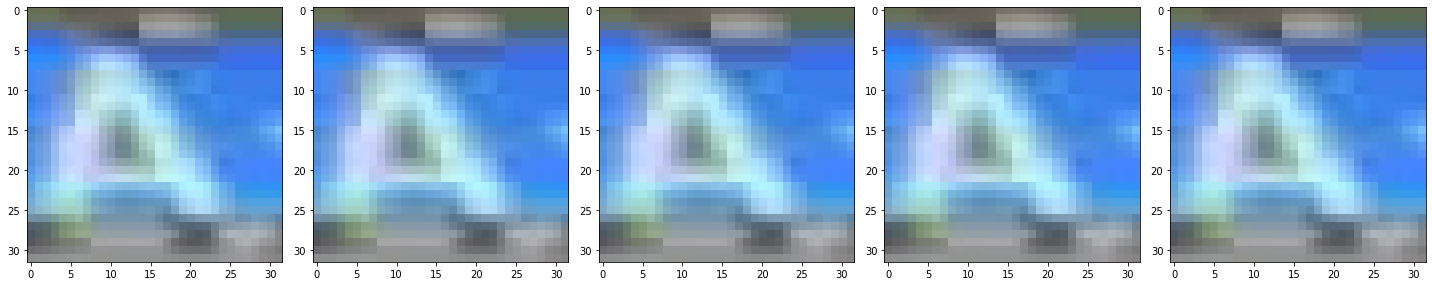

In [20]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_generator[0][0][0] for i in range(25)]
plotImages(augmented_images)

In [21]:
# def build_model(num_classes):
#     model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', 
#                            input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
#     tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
#     tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])
#     return model
# model = build_model(num_classes=n_classes)


In [22]:
from    tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

def VGG16(nb_classes, input_shape):
    input_tensor = Input(shape=input_shape)
    # 1st block
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='conv1a')(input_tensor)
    x = Conv2D(64, (3,3), activation='relu', padding='same',name='conv1b')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool1')(x)
    # 2nd block
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='conv2a')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same',name='conv2b')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool2')(x)
    # 3rd block
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='conv3a')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='conv3b')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same',name='conv3c')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool3')(x)
    # 4th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv4a')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv4b')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv4c')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool4')(x)
    # 5th block
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv5a')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv5b')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same',name='conv5c')(x)
    x = MaxPooling2D((2,2), strides=(2,2), name = 'pool5')(x)
    # full connection
    x = Flatten()(x)
    x = Dense(4096, activation='relu',  name='fc6')(x)
    # x = Dropout(0.6)(x)
    x = Dense(4096, activation='relu', name='fc7')(x)
    # x = Dropout(0.6)(x)
    output_tensor = Dense(nb_classes, activation='softmax', name='fc8')(x)

    model = Model(input_tensor, output_tensor)
    return model

model=VGG16(n_classes, (IMAGE_HEIGHT, IMAGE_WIDTH, 3))

In [23]:
# model = tf.keras.applications.VGG19(
#     include_top=False, weights=None, input_tensor=None,
#     input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3), classes=n_classes,
#     classifier_activation='softmax'
# )

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.00005),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 50

with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                        steps_per_epoch=train_generator.samples // BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=valid_generator,
                        validation_steps= valid_generator.samples // BATCH_SIZE,
                        verbose=1
                        )


Epoch 1/50
220/220 [==============================] - 20s 84ms/step - loss: 3.1243 - accuracy: 0.1649 - val_loss: 2.8075 - val_accuracy: 0.1690
Epoch 2/50
220/220 [==============================] - 18s 83ms/step - loss: 2.3617 - accuracy: 0.2969 - val_loss: 1.8587 - val_accuracy: 0.3900
Epoch 3/50
220/220 [==============================] - 18s 83ms/step - loss: 1.4721 - accuracy: 0.5026 - val_loss: 1.1515 - val_accuracy: 0.5440
Epoch 4/50
220/220 [==============================] - 19s 86ms/step - loss: 0.9801 - accuracy: 0.6694 - val_loss: 0.7566 - val_accuracy: 0.7569
Epoch 5/50
220/220 [==============================] - 21s 94ms/step - loss: 0.5843 - accuracy: 0.8075 - val_loss: 0.3850 - val_accuracy: 0.8611
Epoch 6/50
220/220 [==============================] - 21s 94ms/step - loss: 0.3698 - accuracy: 0.8768 - val_loss: 0.2648 - val_accuracy: 0.9086
Epoch 7/50
220/220 [==============================] - 20s 93ms/step - loss: 0.2553 - accuracy: 0.9147 - val_loss: 0.2957 - val_accuracy:

In [24]:
modelVG = tf.keras.applications.VGG19(
    include_top=False, weights=None, input_tensor=None,
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3), classes=n_classes,
    classifier_activation='softmax'
)

In [25]:
results = model.evaluate(test_generator,batch_size=BATCH_SIZE)

68/68 [==============================] - 2s 29ms/step - loss: 0.1082 - accuracy: 0.9917


In [26]:
model.save(' modelClasNew.h5')



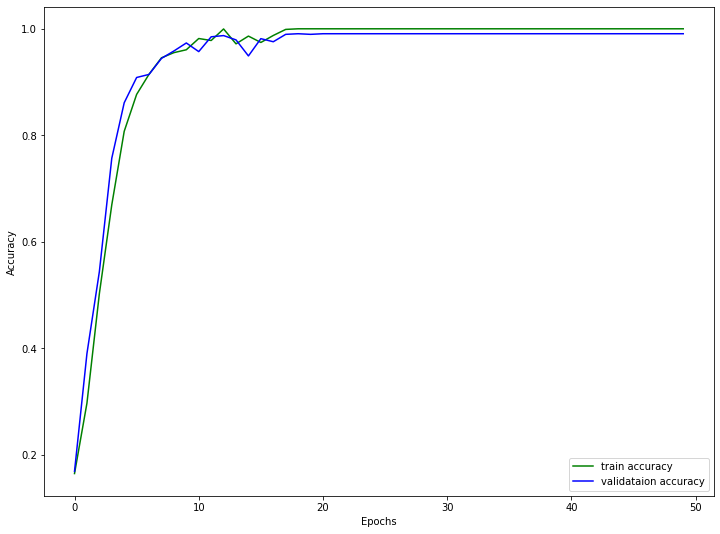

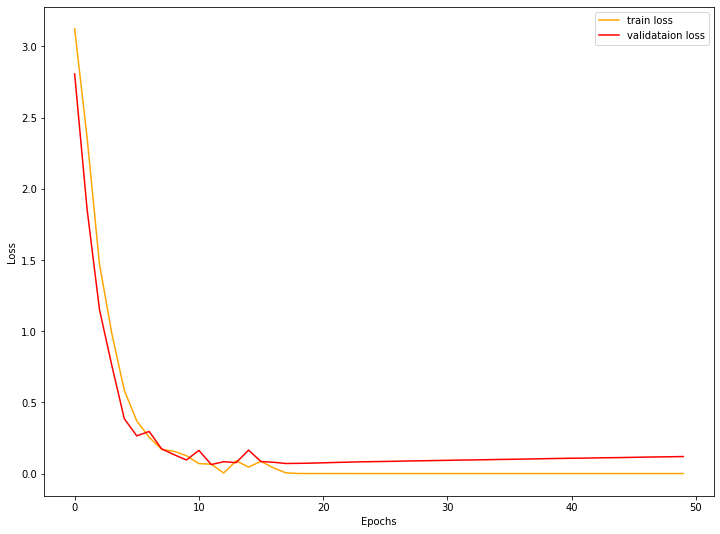

In [27]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()
    # loss plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # plt.savefig('loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [28]:
import numpy as np
a = np.asarray([train_acc,valid_acc,train_loss,valid_loss])
np.savetxt("model_new_data.csv", a, delimiter=",")